# Titanic: Predicting survivors using Random Forest Classifiers

### Importing libraries

In [65]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

plt.style.use('ggplot')
sns.set_palette('muted')

import warnings
warnings.filterwarnings('ignore')


# Set display options to show all columns of a dataframe
pd.set_option('display.max_columns', None)

### Loading data

In [66]:
test_data_raw = pd.read_csv('test.csv')
train_data_raw = pd.read_csv('train.csv')
#df_raw = pd.concat([train_data_raw, test_data_raw], axis = 0)

In [67]:
train_data_raw

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [68]:
split_point = train_data_raw.shape[0]

### Step 1: Data understanding

In [69]:
df = train_data_raw.copy()
test_submission_df = test_data_raw.copy()
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [70]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [71]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

#### General:

In [72]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

No duplicated values.

In [73]:
df.loc[df.duplicated()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [44]:
# Changing object data type to string in the dataframe
obj_features = df.select_dtypes(include='object').columns
df[obj_features] = df[obj_features].astype('string')
test_submission_df[obj_features] = test_submission_df[obj_features].astype('string')

#### Age:
The Age column as 20% missing data.

In [74]:
missing = df['Age'].isna().sum()
print('Missing age data: {}'.format(missing))
print('Percentage missing: {}'.format(missing/df.shape[0]*100))

Missing age data: 177
Percentage missing: 19.865319865319865


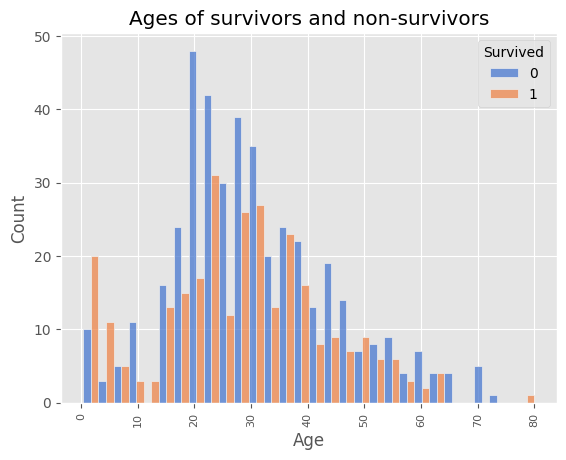

In [46]:
column_x = 'Age'
sns.histplot(data= df, x=column_x, hue='Survived',multiple='dodge',bins=30)
plt.xlabel(column_x.title(),fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.ylabel('Count',fontsize=12)
plt.title('Ages of survivors and non-survivors')
# Get the current legend
legend = plt.gca().get_legend()
legend.set_title('Survived')
plt.show()

#### Fare:
Fare has one missing value.

In [75]:
df.loc[df['Fare'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [76]:
test_submission_df.loc[test_submission_df['Fare'].isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


This passenger was in the 3rd class. Replacing this missing fare value with the mean of all fares payed by 3rd class passengers.

In [77]:
test_submission_df.query('Pclass == 3')['Fare'].mean()

12.459677880184334

In [78]:
test_submission_df.loc[test_submission_df['Fare'].isna(), 'Fare'] = 12.4697
test_submission_df.query('PassengerId == 1044')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,12.4697,NaN,S


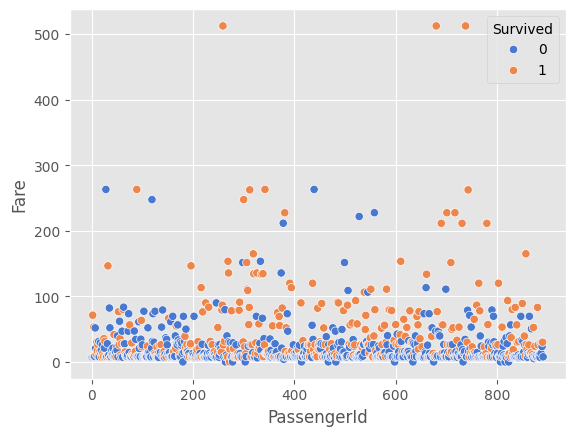

In [79]:
sns.scatterplot(data = df, x='PassengerId', y='Fare', hue='Survived')
plt.show()

#### Cabin:

Cabin has 77% missing data. However the fact that a cabin number has been recorded seems to favour survivorship.

In [83]:
df['Cabin'].value_counts(dropna=False)

Cabin
NaN            687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: count, Length: 148, dtype: int64

In [87]:
missing = df['Cabin'].isna().sum()
print('Missing age data: {}'.format(missing))
print('Percentage missing: {}'.format(missing/df.shape[0]*100))

Missing age data: 687
Percentage missing: 77.10437710437711


Checking if cabin letter has anything to do with passenger class and hence survival rate.

In [89]:
df['Cabin_Letter'] = df['Cabin'].map(lambda cabin: str(cabin)[0])
df['Cabin_Letter'].value_counts()

Cabin_Letter
n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

In [91]:
df['Survived'].groupby(df['Cabin_Letter']).mean()

Cabin_Letter
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
n    0.299854
Name: Survived, dtype: float64

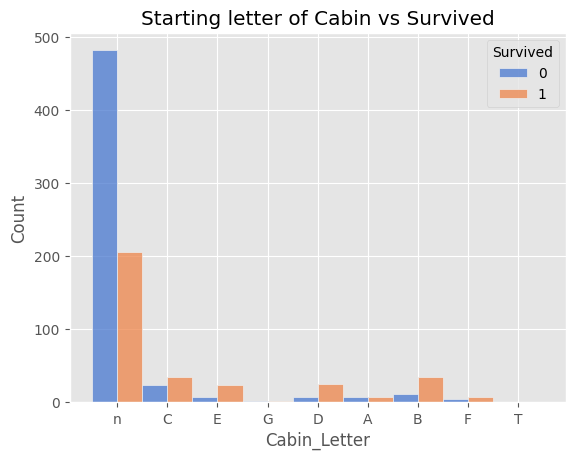

In [93]:
sns.histplot(data = df, x = 'Cabin_Letter', hue='Survived', multiple='dodge')
plt.title('Starting letter of Cabin vs Survived')
plt.show()

Based on the above chart, it's a good idea to have a binary representation on whether the individual has a record for cabin or not. Maybe do some label encoding with the letters but I'm not sure as of now.

#### PassengerId:
Dropping this column.

In [69]:
df.drop(columns=['PassengerId'], inplace=True)

#### Name:

##### Title in name
Extracting title from these names in the hope that some titles might seem "important". The title appears with the '.' in Name.

In [94]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Letter
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,n
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,n
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,n
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,B
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,n
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,C


In [95]:
df['Name_Title'] = df['Name'].map(lambda name: re.search(r'\w*\.', name).group()) 
df['Name_Title'].value_counts()

Name_Title
Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
Countess.      1
Capt.          1
Ms.            1
Sir.           1
Lady.          1
Mme.           1
Don.           1
Jonkheer.      1
Name: count, dtype: int64

In [97]:
df['Survived'].groupby(df['Name_Title']).mean().sort_values(ascending=False)

Name_Title
Sir.         1.000000
Countess.    1.000000
Ms.          1.000000
Mme.         1.000000
Lady.        1.000000
Mlle.        1.000000
Mrs.         0.792000
Miss.        0.697802
Master.      0.575000
Col.         0.500000
Major.       0.500000
Dr.          0.428571
Mr.          0.156673
Jonkheer.    0.000000
Don.         0.000000
Rev.         0.000000
Capt.        0.000000
Name: Survived, dtype: float64

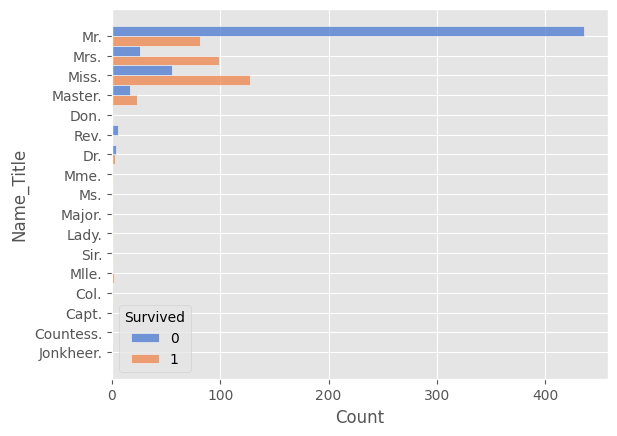

In [101]:
sns.histplot(data = df, y='Name_Title', hue='Survived', multiple='dodge')
plt.show()

##### Length of the name

Length of the name also seems to be a factor. Longer the name, higher the chances of survival. Dividing the length of name into 5 bins with roughly equal number of people and checking their rate of survival.

In [73]:
df['Name_Length'] = df['Name'].map(lambda name: len(name))
df['Survived'].groupby(pd.qcut(df['Name_Length'], 5)).mean()

Name_Length
(11.999, 19.0]    0.220588
(19.0, 23.2]      0.301282
(23.2, 27.0]      0.319797
(27.0, 32.0]      0.442424
(32.0, 82.0]      0.674556
Name: Survived, dtype: float64

#### Embarked:
2 unnacounted for, filled missing data with 'S' since that is most common and the statistics after replacement change less than 1%.

In [74]:
df['Embarked'].value_counts()

Embarked
S       914
C       270
Q       123
None      2
Name: count, dtype: int64

In [75]:
df.loc[df['Embarked']=='None', 'Embarked'] = 'S'
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Name_Title,Name_Length
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr.,23
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs.,51
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss.,22
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs.,44
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr.,24
...,...,...,...,...,...,...,...,...,...,...,...,...
413,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,S,Mr.,18
414,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,Dona.,28
415,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,Mr.,28
416,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,S,Mr.,19


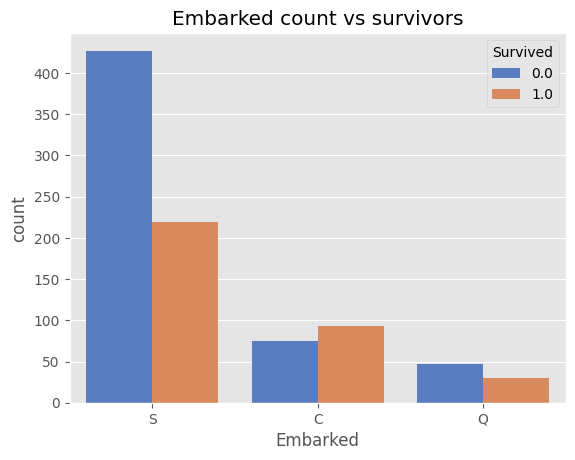

In [76]:
ax = sns.countplot(data=df, x='Embarked', hue='Survived')
ax.set_title('Embarked count vs survivors')
plt.show()

#### PClass:

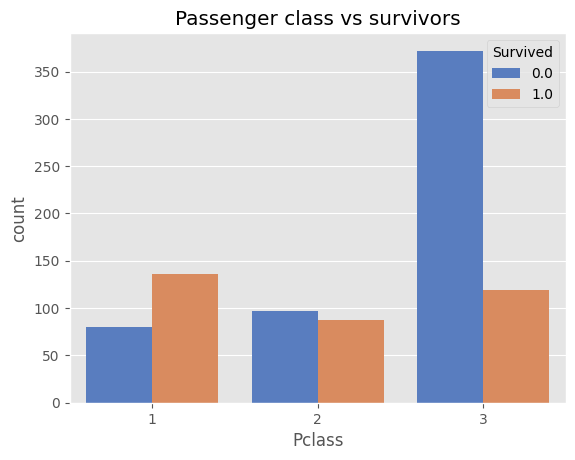

In [77]:
ax = sns.countplot(data=df, x='Pclass', hue='Survived')
ax.set_title('Passenger class vs survivors')
plt.show()

#### Ticket:
Dropping Ticket column as Fare and Pclass columns give more relavant information.

In [78]:
df['Ticket'].value_counts()

Ticket
CA. 2343        11
CA 2144          8
1601             8
PC 17608         7
S.O.C. 14879     7
                ..
113792           1
36209            1
323592           1
315089           1
359309           1
Name: count, Length: 929, dtype: int64

In [79]:
df.drop(columns='Ticket', inplace=True)

#### Siblings/Spouse and Parents/Children:

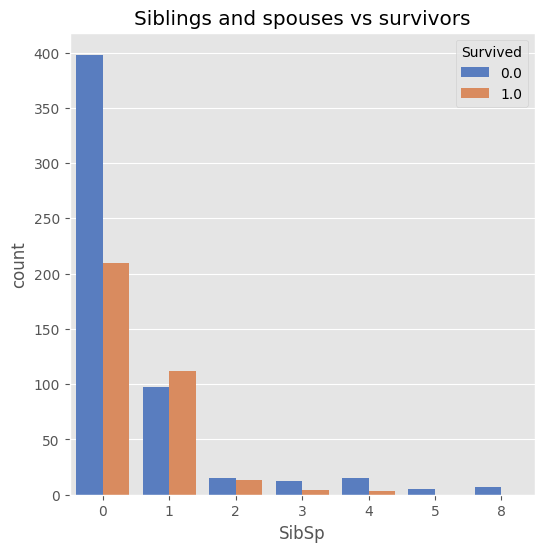

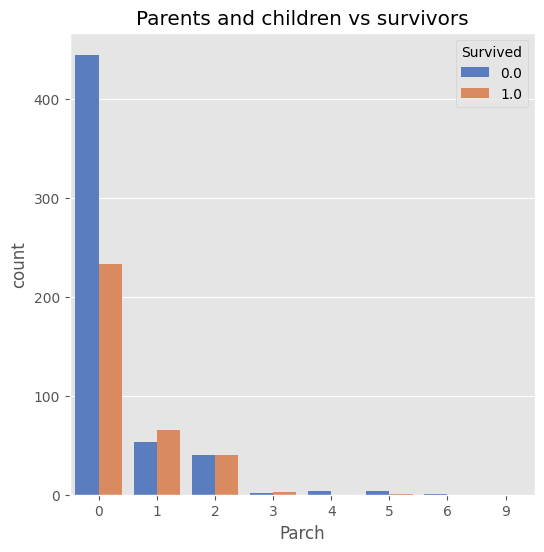

In [80]:
plt.figure(figsize=(6,6))
ax = sns.countplot(data=df, x='SibSp', hue='Survived')
ax.set_title('Siblings and spouses vs survivors')


plt.figure(figsize=(6,6))
ax = sns.countplot(data=df, x='Parch', hue='Survived')
ax.set_title('Parents and children vs survivors')

plt.show()

#### Gender:
Females have a higer survival rate.

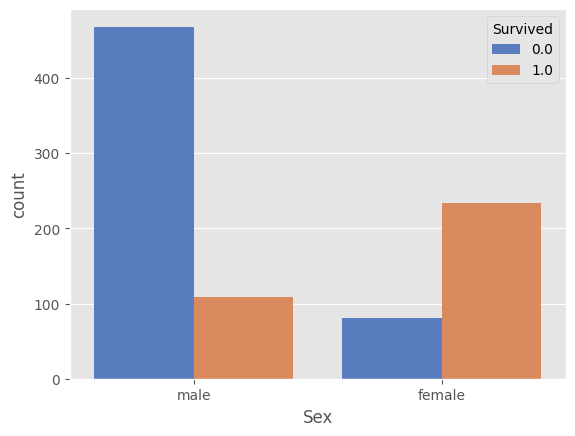

In [81]:
sns.countplot(data=df, x='Sex', hue='Survived')
plt.show()

### Step 2: Data Preparation

#### Age:

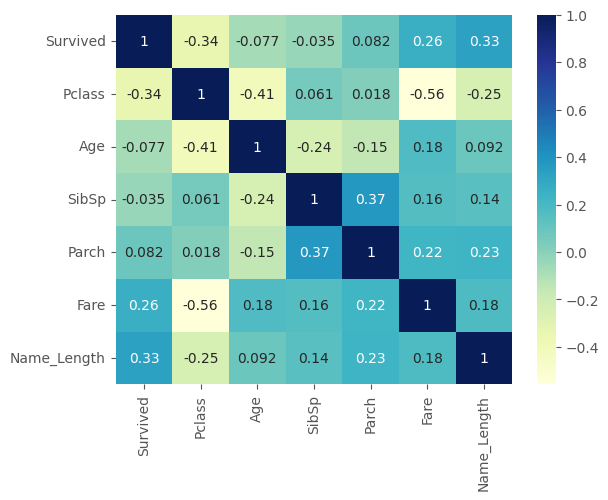

In [82]:
sns.heatmap(df.corr(numeric_only = True), annot=True, cmap='YlGnBu')
plt.show()

In [83]:
df['Age'].describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

In [84]:
df['Age'].isna()

0      False
1      False
2      False
3      False
4      False
       ...  
413     True
414    False
415    False
416     True
417     True
Name: Age, Length: 1309, dtype: bool

In [85]:
print('Mean age of men: {}\nMean age of women: {}'.format(df[df['Sex']== 'male']['Age'].mean(), df[df['Sex']== 'female']['Age'].mean()))

Mean age of men: 30.58522796352584
Mean age of women: 28.68708762886598


The mean age isn't too different so there's no sense in imputing age based on gender (this was my initial plan). Maybe we do a basic straightforward mean imputation and see whether that changes the correlation factor.

In [86]:
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Name_Title,Name_Length
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr.,23
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs.,51
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss.,22
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs.,44
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr.,24
...,...,...,...,...,...,...,...,...,...,...,...
413,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,8.0500,S,Mr.,18
414,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,108.9000,C,Dona.,28
415,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,7.2500,S,Mr.,28
416,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,8.0500,S,Mr.,19


In [87]:
train_data = df.iloc[:split_point]
test_data = df.iloc[split_point:]

train_data['Age'] = train_data['Age'].fillna(train_data['Age'].mean())
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].mean())
df = pd.concat([train_data, test_data], axis=0)

### Step 3: Feature Engineering

In [88]:
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Name_Title,Name_Length
0,0.0,3,"Braund, Mr. Owen Harris",male,22.00000,1,0,7.2500,S,Mr.,23
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00000,1,0,71.2833,C,Mrs.,51
2,1.0,3,"Heikkinen, Miss. Laina",female,26.00000,0,0,7.9250,S,Miss.,22
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00000,1,0,53.1000,S,Mrs.,44
4,0.0,3,"Allen, Mr. William Henry",male,35.00000,0,0,8.0500,S,Mr.,24
...,...,...,...,...,...,...,...,...,...,...,...
413,NaN,3,"Spector, Mr. Woolf",male,30.27259,0,0,8.0500,S,Mr.,18
414,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.00000,0,0,108.9000,C,Dona.,28
415,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.50000,0,0,7.2500,S,Mr.,28
416,NaN,3,"Ware, Mr. Frederick",male,30.27259,0,0,8.0500,S,Mr.,19


#### Pclass v Fare

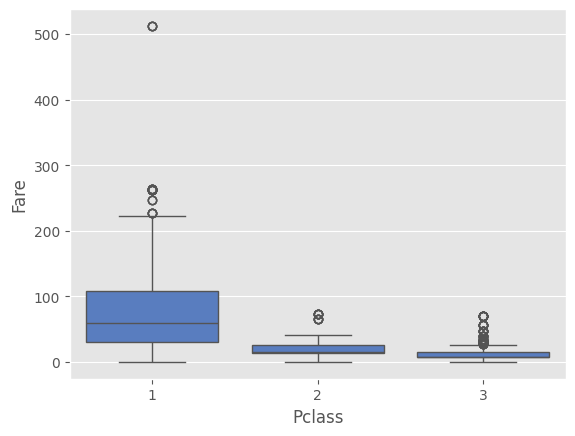

In [89]:
sns.boxplot(data = df, x = 'Pclass', y='Fare')
plt.show()

#### Gender

Converting male to 1 and female to 0.

In [90]:
df['Sex'] = df['Sex'].map(lambda gender: 0 if gender == 'female' else 1)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Name_Title,Name_Length
0,0.0,3,"Braund, Mr. Owen Harris",1,22.00000,1,0,7.2500,S,Mr.,23
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.00000,1,0,71.2833,C,Mrs.,51
2,1.0,3,"Heikkinen, Miss. Laina",0,26.00000,0,0,7.9250,S,Miss.,22
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.00000,1,0,53.1000,S,Mrs.,44
4,0.0,3,"Allen, Mr. William Henry",1,35.00000,0,0,8.0500,S,Mr.,24
...,...,...,...,...,...,...,...,...,...,...,...
413,NaN,3,"Spector, Mr. Woolf",1,30.27259,0,0,8.0500,S,Mr.,18
414,NaN,1,"Oliva y Ocana, Dona. Fermina",0,39.00000,0,0,108.9000,C,Dona.,28
415,NaN,3,"Saether, Mr. Simon Sivertsen",1,38.50000,0,0,7.2500,S,Mr.,28
416,NaN,3,"Ware, Mr. Frederick",1,30.27259,0,0,8.0500,S,Mr.,19


#### Embarked

In [91]:
# One hot encoding fixing dummy variable trap
# Could have used drop_first=True in the line below but chose to remove Embarked_Q as Q has the fewest passengers embarking and 
# its correlation to survivros is negligible.
dummies = pd.get_dummies(df['Embarked'], dtype='int', prefix = 'Embarked')
df = pd.concat([df, dummies], axis = 1)
df.drop(columns=['Embarked', 'Embarked_Q'], inplace=True)

In [92]:
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Name_Title,Name_Length,Embarked_C,Embarked_S
0,0.0,3,"Braund, Mr. Owen Harris",1,22.00000,1,0,7.2500,Mr.,23,0,1
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.00000,1,0,71.2833,Mrs.,51,1,0
2,1.0,3,"Heikkinen, Miss. Laina",0,26.00000,0,0,7.9250,Miss.,22,0,1
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.00000,1,0,53.1000,Mrs.,44,0,1
4,0.0,3,"Allen, Mr. William Henry",1,35.00000,0,0,8.0500,Mr.,24,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,NaN,3,"Spector, Mr. Woolf",1,30.27259,0,0,8.0500,Mr.,18,0,1
414,NaN,1,"Oliva y Ocana, Dona. Fermina",0,39.00000,0,0,108.9000,Dona.,28,1,0
415,NaN,3,"Saether, Mr. Simon Sivertsen",1,38.50000,0,0,7.2500,Mr.,28,0,1
416,NaN,3,"Ware, Mr. Frederick",1,30.27259,0,0,8.0500,Mr.,19,0,1


In [93]:
# Split the data again
train_data = df.iloc[:split_point]
test_data = df.iloc[split_point:]

In [94]:
train_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Name_Title,Name_Length,Embarked_C,Embarked_S
0,0.0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,7.2500,Mr.,23,0,1
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000000,1,0,71.2833,Mrs.,51,1,0
2,1.0,3,"Heikkinen, Miss. Laina",0,26.000000,0,0,7.9250,Miss.,22,0,1
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000000,1,0,53.1000,Mrs.,44,0,1
4,0.0,3,"Allen, Mr. William Henry",1,35.000000,0,0,8.0500,Mr.,24,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,2,"Montvila, Rev. Juozas",1,27.000000,0,0,13.0000,Rev.,21,0,1
887,1.0,1,"Graham, Miss. Margaret Edith",0,19.000000,0,0,30.0000,Miss.,28,0,1
888,0.0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,29.699118,1,2,23.4500,Miss.,40,0,1
889,1.0,1,"Behr, Mr. Karl Howell",1,26.000000,0,0,30.0000,Mr.,21,1,0


In [95]:
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Name_Title,Name_Length,Embarked_C,Embarked_S
0,0.0,3,"Braund, Mr. Owen Harris",1,22.00000,1,0,7.2500,Mr.,23,0,1
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.00000,1,0,71.2833,Mrs.,51,1,0
2,1.0,3,"Heikkinen, Miss. Laina",0,26.00000,0,0,7.9250,Miss.,22,0,1
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.00000,1,0,53.1000,Mrs.,44,0,1
4,0.0,3,"Allen, Mr. William Henry",1,35.00000,0,0,8.0500,Mr.,24,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,NaN,3,"Spector, Mr. Woolf",1,30.27259,0,0,8.0500,Mr.,18,0,1
414,NaN,1,"Oliva y Ocana, Dona. Fermina",0,39.00000,0,0,108.9000,Dona.,28,1,0
415,NaN,3,"Saether, Mr. Simon Sivertsen",1,38.50000,0,0,7.2500,Mr.,28,0,1
416,NaN,3,"Ware, Mr. Frederick",1,30.27259,0,0,8.0500,Mr.,19,0,1


In [96]:
test_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Name_Title,Name_Length,Embarked_C,Embarked_S
0,NaN,3,"Kelly, Mr. James",1,34.50000,0,0,7.8292,Mr.,16,0,0
1,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.00000,1,0,7.0000,Mrs.,32,0,1
2,NaN,2,"Myles, Mr. Thomas Francis",1,62.00000,0,0,9.6875,Mr.,25,0,0
3,NaN,3,"Wirz, Mr. Albert",1,27.00000,0,0,8.6625,Mr.,16,0,1
4,NaN,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.00000,1,1,12.2875,Mrs.,44,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,NaN,3,"Spector, Mr. Woolf",1,30.27259,0,0,8.0500,Mr.,18,0,1
414,NaN,1,"Oliva y Ocana, Dona. Fermina",0,39.00000,0,0,108.9000,Dona.,28,1,0
415,NaN,3,"Saether, Mr. Simon Sivertsen",1,38.50000,0,0,7.2500,Mr.,28,0,1
416,NaN,3,"Ware, Mr. Frederick",1,30.27259,0,0,8.0500,Mr.,19,0,1


### Step 4: Scaling data

Using the MinMax Scaler on SibSp and Parch, Fare and Pclass-Fare.
Using the Standard Scaler on Age.

In [97]:
scaler = MinMaxScaler()
train_data[['SibSp', 'Parch', 'Fare']] = scaler.fit_transform(train_data[['SibSp', 'Parch', 'Fare']])
test_data[['SibSp', 'Parch', 'Fare']] = scaler.fit_transform(test_data[['SibSp', 'Parch', 'Fare']])

In [98]:
train_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Name_Title,Name_Length,Embarked_C,Embarked_S
0,0.0,3,"Braund, Mr. Owen Harris",1,22.000000,0.125,0.000000,0.014151,Mr.,23,0,1
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000000,0.125,0.000000,0.139136,Mrs.,51,1,0
2,1.0,3,"Heikkinen, Miss. Laina",0,26.000000,0.000,0.000000,0.015469,Miss.,22,0,1
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000000,0.125,0.000000,0.103644,Mrs.,44,0,1
4,0.0,3,"Allen, Mr. William Henry",1,35.000000,0.000,0.000000,0.015713,Mr.,24,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,2,"Montvila, Rev. Juozas",1,27.000000,0.000,0.000000,0.025374,Rev.,21,0,1
887,1.0,1,"Graham, Miss. Margaret Edith",0,19.000000,0.000,0.000000,0.058556,Miss.,28,0,1
888,0.0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,29.699118,0.125,0.333333,0.045771,Miss.,40,0,1
889,1.0,1,"Behr, Mr. Karl Howell",1,26.000000,0.000,0.000000,0.058556,Mr.,21,1,0


In [99]:
scaler = StandardScaler()
train_data[['Age']] = scaler.fit_transform(train_data[['Age']])
test_data[['Age']] = scaler.fit_transform(test_data[['Age']])

### Step 5: Implementing model

Splitting the train data into x_test and x_train as test dataset here does not have survivor info. So we need to check how the model is performing on part of the train set itself.

In [100]:
shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_indices, test_indices in shuffle_split.split(train_data, train_data[['Survived', 'Sex', 'Pclass']]):
    x_train = train_data.loc[train_indices]
    x_test = train_data.loc[test_indices]

Also separating 'Survived' column from the test and train data.

In [101]:
y_train = x_train['Survived']
x_train.drop(columns='Survived', inplace=True)
y_test = x_test['Survived']
x_test.drop(columns='Survived', inplace=True)

Using GridSearchCV for hyperparameter tuning.

In [102]:
param_grid = [{'n_estimators': [10, 100, 200, 500],
               'max_depth': [10, 15, None],
               'min_samples_split': [3, 4, 5, 6]}]

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, return_train_score=True, verbose=True)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


ValueError: 
All the 240 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/arpitha/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/arpitha/.local/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arpitha/.local/lib/python3.11/site-packages/sklearn/ensemble/_forest.py", line 363, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/arpitha/.local/lib/python3.11/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arpitha/.local/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/arpitha/.local/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arpitha/.local/lib/python3.11/site-packages/sklearn/utils/_array_api.py", line 745, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/pandas/core/generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Doharr, Mr. Tannous'

--------------------------------------------------------------------------------
192 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/arpitha/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/arpitha/.local/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arpitha/.local/lib/python3.11/site-packages/sklearn/ensemble/_forest.py", line 363, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/arpitha/.local/lib/python3.11/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arpitha/.local/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/arpitha/.local/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arpitha/.local/lib/python3.11/site-packages/sklearn/utils/_array_api.py", line 745, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/pandas/core/generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Icard, Miss. Amelie'


Save the model so you don't have to run Gridsearchcv again.

In [368]:
# Access the best model
best_model = grid_search.best_estimator_

# Save the best model to a file using joblib
joblib.dump(best_model, 'best_random_forest_model.pkl')

['best_random_forest_model.pkl']

grid_search.cv_results_ is a dictonary of each iteration of grid search, saving parameters and test and train scores. Converting that to a df and saving as a csv so can be accessed whenever.

In [369]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df.to_csv('cv_results.csv')

In [370]:
cv_results_df = pd.read_csv('cv_results.csv')
# Keeping only some important columns.
cv_results_df = cv_results_df[['param_max_depth', 'param_min_samples_split', 'param_n_estimators', 'mean_test_score', 'std_test_score', 'rank_test_score', 'mean_train_score', 'std_train_score']]

# Sorting the data by rank_test_score from best to worst.
cv_results_df.sort_values('rank_test_score', ascending=True).head()

,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
5,10.0,4,100,0.831429,0.015093,1,0.928369,0.003940
9,10.0,5,100,0.827233,0.006006,2,0.923099,0.006288
15,10.0,6,500,0.825845,0.012062,3,0.917833,0.007015
11,10.0,5,500,0.825835,0.005486,4,0.922047,0.004006
10,10.0,5,200,0.824446,0.009768,5,0.922752,0.004030


In [371]:
# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 100}
Best cross-validation score:  0.8314291342460358


In [372]:
best_rfc = joblib.load('best_random_forest_model.pkl')

Now using the best RFC on the test data (of the training set) to see how it performs. (Is this even necessary given the crossvalidation score?) 

In [373]:
y_pred = best_rfc.predict(x_test)
  
print("-----Test Data Accuracy----")
a_s = round(accuracy_score(y_test.to_numpy(), y_pred), 6)
print('Accuracy score:', a_s)
f_1 = round(f1_score(y_test.to_numpy(), y_pred), 6)
print('F1 score:', f_1)


-----Test Data Accuracy----
Accuracy score: 0.837989
F1 score: 0.775194


### Comments:

As can be seen from the lines below, something can be done about survivors who were predicted dead being mostly males. Model could be skewed to predict more males dying than females. Things that were tried to fix this:
1. New feature: PClass-Fare = (4 - PClass)*Fare to address that first class passengers pay more, but this ended up being highly correlated to Fare, so discarded.
2. High-Fare = 1 if fare>60, else 0. This simple feature made the model a tad worse. An increase in this particular misclassification by 1.

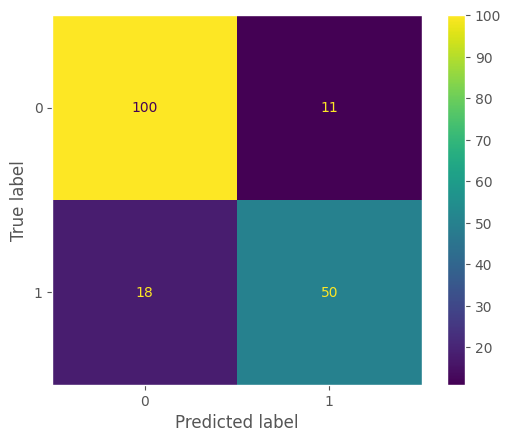

In [374]:
CM_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels = [0, 1])

CM_display.plot()
plt.grid(False) # Removes white grid lines that block numbers
plt.show() 

In [375]:
test_temp = train_data_raw.iloc[test_indices]
test_temp['Predicted'] = y_pred
test_temp

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Predicted
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S,0.0
817,818,0,2,"Mallet, Mr. Albert",male,31.0,1,1,S.C./PARIS 2079,37.0042,NaN,C,0.0
484,485,1,1,"Bishop, Mr. Dickinson H",male,25.0,1,0,11967,91.0792,B49,C,0.0
67,68,0,3,"Crease, Mr. Ernest James",male,19.0,0,0,S.P. 3464,8.1583,NaN,S,0.0
839,840,1,1,"Marechal, Mr. Pierre",male,NaN,0,0,11774,29.7000,C47,C,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
780,781,1,3,"Ayoub, Miss. Banoura",female,13.0,0,0,2687,7.2292,NaN,C,1.0
687,688,0,3,"Dakic, Mr. Branko",male,19.0,0,0,349228,10.1708,NaN,S,0.0
538,539,0,3,"Risien, Mr. Samuel Beard",male,NaN,0,0,364498,14.5000,NaN,S,0.0
22,23,1,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q,1.0


In [376]:
test_temp[(test_temp['Survived']==1) & (test_temp['Predicted']==0)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Predicted
484,485,1,1,"Bishop, Mr. Dickinson H",male,25.0,1,0,11967,91.0792,B49,C,0.0
839,840,1,1,"Marechal, Mr. Pierre",male,NaN,0,0,11774,29.7000,C47,C,0.0
553,554,1,3,"Leeni, Mr. Fahim (""Philip Zenni"")",male,22.0,0,0,2620,7.2250,NaN,C,0.0
455,456,1,3,"Jalsevac, Mr. Ivan",male,29.0,0,0,349240,7.8958,NaN,C,0.0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0.0
267,268,1,3,"Persson, Mr. Ernst Ulrik",male,25.0,1,0,347083,7.7750,NaN,S,0.0
21,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S,0.0
449,450,1,1,"Peuchen, Major. Arthur Godfrey",male,52.0,0,0,113786,30.5000,C104,S,0.0
828,829,1,3,"McCormack, Mr. Thomas Joseph",male,NaN,0,0,367228,7.7500,NaN,Q,0.0
489,490,1,3,"Coutts, Master. Eden Leslie ""Neville""",male,9.0,1,1,C.A. 37671,15.9000,NaN,S,0.0


### Step 6: Predict survivors

In [377]:
test_data.drop(columns='Survived', inplace=True)

In [378]:
test_data

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_S
0,3,1,0.334993,0.000,0.000000,0.015282,0,0
1,3,0,1.325530,0.125,0.000000,0.013663,0,1
2,2,1,2.514175,0.000,0.000000,0.018909,0,0
3,3,1,-0.259330,0.000,0.000000,0.016908,0,1
4,3,0,-0.655545,0.125,0.111111,0.023984,0,1
...,...,...,...,...,...,...,...,...
413,3,1,0.000000,0.000,0.000000,0.015713,0,1
414,1,0,0.691586,0.000,0.000000,0.212559,1,0
415,3,1,0.651965,0.000,0.000000,0.014151,0,1
416,3,1,0.000000,0.000,0.000000,0.015713,0,1


In [379]:
y_final_pred = best_rfc.predict(test_data)


In [380]:
test_data_raw['Survived'] = y_final_pred
test_data_raw

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0.0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1.0
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0.0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0.0


In [381]:
submission = test_data_raw[['PassengerId', 'Survived']]
submission['Survived'] = submission['Survived'].astype('int')
submission = submission.reset_index(drop=True)
submission.to_csv('submission.csv', index=False)

In [382]:
submission.dtypes

PassengerId    int64
Survived       int64
dtype: object